## Lesson 3 Lecture Follow Along and Experimentation

In [1]:
import matplotlib.pyplot as plt
import torch

plt.rc('figure', dpi=90)

def plot_function(f, title=None, min=-2.1, max=2.1, color='r', ylim=None):
    x = torch.linspace(min,max, 100)[:,None]
    if ylim: plt.ylim(ylim)
    plt.plot(x, f(x), color)
    if title is not None: plt.title(title)

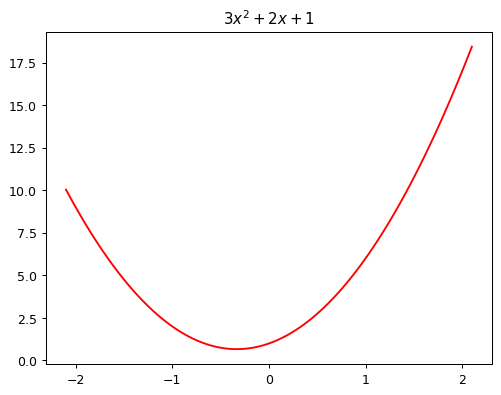

In [3]:
def f(x): return 3*x**2 + 2*x + 1

plot_function(f, "$3x^2 + 2x + 1$")

In [4]:
def quad(a, b, c, x): return a*x**2 + b*x + c

In [5]:
quad(3, 2, 1, 1.5)

10.75

In [6]:
from functools import partial
def mk_quad(a,b,c): return partial(quad, a,b,c)

In [7]:
f = mk_quad(3,2,1)
f(1.5)

10.75

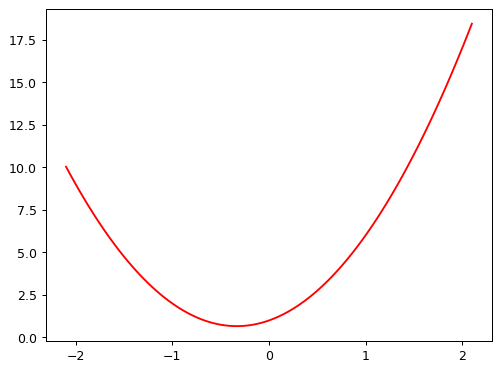

In [8]:
plot_function(f)

In [9]:
import numpy as np
from numpy.random import normal,seed,uniform
np.random.seed(42)

def noise(x, scale): return normal(scale=scale, size=x.shape)
def add_noise(x, mult, add): return x * (1+noise(x, mult)) + noise(x,add)

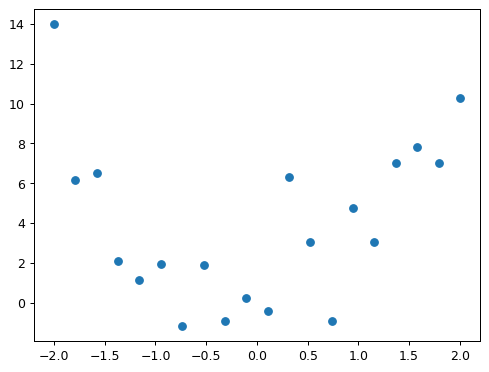

In [10]:
import torch

x = torch.linspace(-2, 2, steps=20)[:,None]
y = add_noise(f(x), 0.3, 2.5)
plt.scatter(x, y)

## Working through the above functions

In [11]:
linspaceResult = torch.linspace(-20, 20, 10)
linspaceResult

tensor([-20.0000, -15.5556, -11.1111,  -6.6667,  -2.2222,   2.2222,   6.6667,
         11.1111,  15.5556,  20.0000])

In [12]:
linTransposed = linspaceResult[:,None]
linTransposed

tensor([[-20.0000],
        [-15.5556],
        [-11.1111],
        [ -6.6667],
        [ -2.2222],
        [  2.2222],
        [  6.6667],
        [ 11.1111],
        [ 15.5556],
        [ 20.0000]])

In [13]:
import torch
ones = torch.ones(5)
print(ones)

norm = normal(ones)
print(norm)

zeros = torch.zeros(5)
print(zeros)

norm = normal(zeros, 0.5)
print(norm)
norm = normal(zeros, 0.5, [8,2,5])
print(norm)

tensor([1., 1., 1., 1., 1.])
[ 1.73846658  1.17136828  0.88435172  0.6988963  -0.47852199]
tensor([0., 0., 0., 0., 0.])
[-0.3599221  -0.23031939  0.52856111  0.17180914 -0.88152008]
[[[ 0.16204198 -0.19254114 -0.338461    0.30583814  0.51549976]
  [ 0.46564006 -0.41960876 -0.15460619  0.16563172  0.48777256]]

 [[-0.23958712 -0.09282949 -0.55316749 -0.59810331  0.40626291]
  [ 0.67812001 -0.03600506  0.50176645  0.18081801 -0.32255988]]

 [[ 0.1806978   0.76901828 -0.01791302  0.78232183 -1.30987255]
  [ 0.41095125  0.04352353 -0.14950368  0.04588039 -0.99378446]]

 [[-0.10983594  0.17855629  0.73894702 -0.25913511 -0.4042468 ]
  [-0.25087852  0.45770106  0.16437555 -0.2648801   0.25663372]]

 [[ 0.04853877  0.4843225  -0.35102655 -0.16383107 -0.19605408]
  [-0.73175747  0.14806014  0.13052764  0.00255673 -0.11729357]]

 [[-0.70768537 -0.21032266 -0.17135726 -0.40113863 -0.08064286]
  [ 0.20202543  0.94309295  0.08728891  0.1287752  -0.03722296]]

 [[-0.95938561 -0.01325694  0.0301151 

## Moving on...

In [14]:
from ipywidgets import interact
@interact(a=1.5, b=1.5, c=1.5)
def plot_quad(a, b, c):
    plt.scatter(x, y)
    plot_function(mk_quad(a, b, c), ylim=(-3,12))

interactive(children=(FloatSlider(value=1.5, description='a', max=4.5, min=-1.5), FloatSlider(value=1.5, descr…

## Loss Function

In [15]:
def mse(x, y): return (x-y).square().mean().sqrt()

In [20]:
@interact(a=1.5, b=1.5, c=1.5)
def plot_quad_loss(a,b,c):
    quad = mk_quad(a,b,c)
    plt.scatter(x,y)
    loss = mse(quad(x), y)
    plot_function(quad, ylim=(-3,12), title=f"MSE: {loss:.2f}")

interactive(children=(FloatSlider(value=1.5, description='a', max=4.5, min=-1.5), FloatSlider(value=1.5, descr…

## Automating Loss Optimization

In [19]:
def quad_mse(params):
    f = mk_quad(*params)
    return mse(f(x), y)

In [21]:
quad_mse([1.5, 1.5, 1.5])

tensor(2.9413, dtype=torch.float64)

In [22]:
abc = torch.tensor([1.5, 1.5, 1.5])
abc.requires_grad_()

tensor([1.5000, 1.5000, 1.5000], requires_grad=True)

In [23]:
loss = quad_mse(abc)
loss

tensor(2.9413, dtype=torch.float64, grad_fn=<SqrtBackward0>)

In [24]:
loss.backward()

In [25]:
abc.grad

tensor([-0.7409,  0.5686, -0.0967])

In [26]:
with torch.no_grad():
    abc -= abc.grad * 0.01
    loss = quad_mse(abc)
    
print(f'loss={loss:.2f}')

loss=2.93


In [28]:
for i in range(5):
    loss = quad_mse(abc)
    loss.backward()
    with torch.no_grad(): abc -= abc.grad*0.01
    print(f'step={i}, loss={loss:.2f}')

step=0, loss=2.78
step=1, loss=2.73
step=2, loss=2.68
step=3, loss=2.64
step=4, loss=2.59


In [29]:
def rectified_linear(m,b,x):
    y = m*x + b
    return torch.clip(y, 0.)

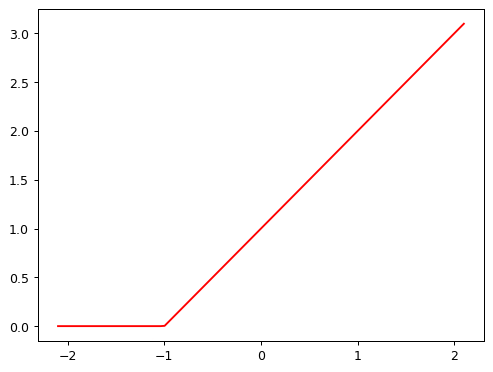

In [30]:
plot_function(partial(rectified_linear, 1, 1))

In [31]:
@interact(m=1.5, b=1.5)
def plot_relu(m,b):
    plot_function(partial(rectified_linear, m, b))

interactive(children=(FloatSlider(value=1.5, description='m', max=4.5, min=-1.5), FloatSlider(value=1.5, descr…

In [33]:
def double_relu(m1,b1,m2,b2,x):
    return rectified_linear(m1,b1,x) + rectified_linear(m2,b2,x)

In [36]:
@interact(m1=1.5, b1=1.5, m2=1.5, b2=1.5)
def plot_relu(m1,b1,m2,b2):
    plot_function(partial(double_relu, m1, b1, m2, b2))

interactive(children=(FloatSlider(value=1.5, description='m1', max=4.5, min=-1.5), FloatSlider(value=1.5, desc…